In [13]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random
#####################################################################################################################################################
import warnings 
warnings.filterwarnings("ignore")

In [2]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
num_epochs = 500
lr = 0.001
num_outputs = 10
seq_len = 100
batch_size = 200
in_features = 2
noise = False
warm_up_epochs = 5
std_variation=True
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000
total params:2114954


In [3]:
%matplotlib inline
model.load_state_dict(torch.load("C:\\Users\\prajb\\OneDrive\\Documents\\TU Delft CSE Masters Y2\\Thesis Projects\\PFN clustering\\models\\saved_model_dirichlet.pt", weights_only=True))
model.eval() 
print("")

In [ ]:
%matplotlib inline
temp_batch_size = 10
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=10, cluster_type='make_blobs')
batch_classes = batch_classes.permute(1,0)
model.eval()
print("") 

In [ ]:
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 2, figsize=(15, 30)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x_true = X_true[:, batch_index].unsqueeze(1)
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    batch = batch_classes[batch_index].unsqueeze(-1)
    axes[2 * batch_index].scatter(train_x_true[:, 0, 0].cpu().numpy() , train_x_true[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits,cluster_output = model(train_x, torch.full(batch.shape, 6, dtype=torch.long, device=device))
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[2 * batch_index +1].scatter(train_x_true[:,0, 0].cpu().numpy() , train_x_true[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    x_max, y_max = train_x_true[:, 0, 0].cpu().max(), train_x_true[:, 0, 1].cpu().max()
    axes[2 * batch_index + 1].text(x_max, y_max, f"Clusters: { torch.unique(predictions).numel()}",fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    axes[2 * batch_index + 1].text(x_max, y_max - 1.5, f"prediction: {predictions_cluster_count.item() + 1}",fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

axes[1].set_title(f"transformer prediction")
axes[0].set_title(f"real data points")
plt.show()

In [221]:
def fill_buckets_dirichlet(total=150, n_buckets=5, alpha=None):
    if alpha is None:
        alpha = np.ones(n_buckets)
    
    proportions = np.random.dirichlet(alpha)

    # Scale to match the total sum
    bucket_counts = np.round(proportions * total).astype(int)

    diff = total - bucket_counts.sum()
    bucket_counts[:abs(diff)] += np.sign(diff)
    bucket_counts += 10
    return bucket_counts

[ 4 30 16 15 35]
Total: 100


In [293]:
%matplotlib inline
temp_batch_size = 1000
seq_len = 500 
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=10, cluster_type='make_blobs')
batch_classes = batch_classes.permute(1,0)
model.eval()
print("") 


Unique values: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
Counts: tensor([107,  94, 117,  80, 104, 101,  93, 105,  98, 101], device='cuda:0')


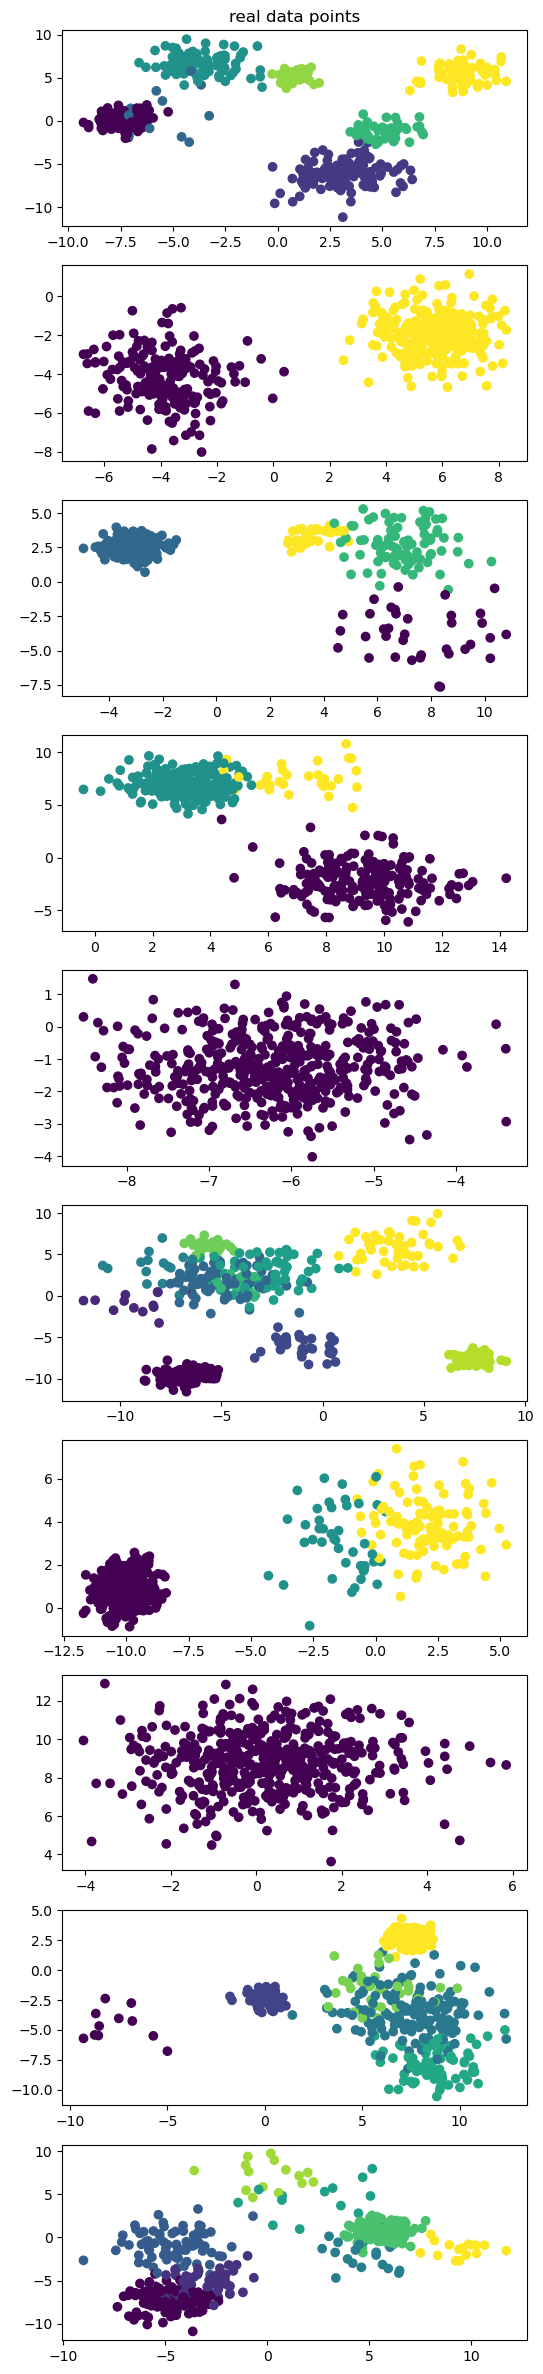

In [291]:
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 1, figsize=(6, 3 * temp_batch_size))
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x_true = X_true[:, batch_index].unsqueeze(1)
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    batch = batch_classes[batch_index].unsqueeze(-1)
    axes[batch_index].scatter(train_x_true[:, 0, 0].cpu().numpy() , train_x_true[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())

axes[0].set_title(f"real data points")
plt.show()

In [4]:
%matplotlib inline
temp_batch_size = 10
seq_len = 500 
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=5, cluster_type='make_blobs')
model.eval()
print("") 

In [14]:
accuracy_buckets_pfn  =utils.compute_accuracy_distribution(train_X, train_Y, batch_classes,model,model_type='transformer')
accuracy_buckets_gmm = utils.compute_accuracy_distribution(X_true, train_Y, batch_classes,model_type='gmm')
accuracy_buckets_kmeans = utils.compute_accuracy_distribution(X_true, train_Y, batch_classes,model,model_type='kmeans')

print(accuracy_buckets_pfn) 
print(accuracy_buckets_gmm) 
print(accuracy_buckets_kmeans) 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


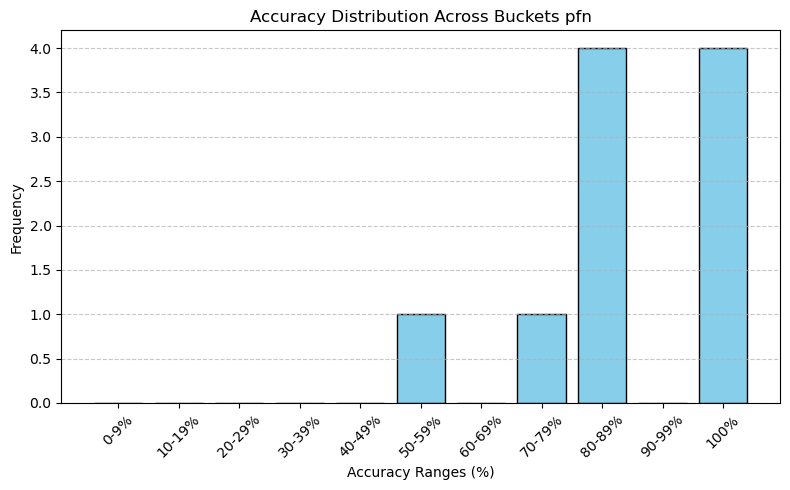

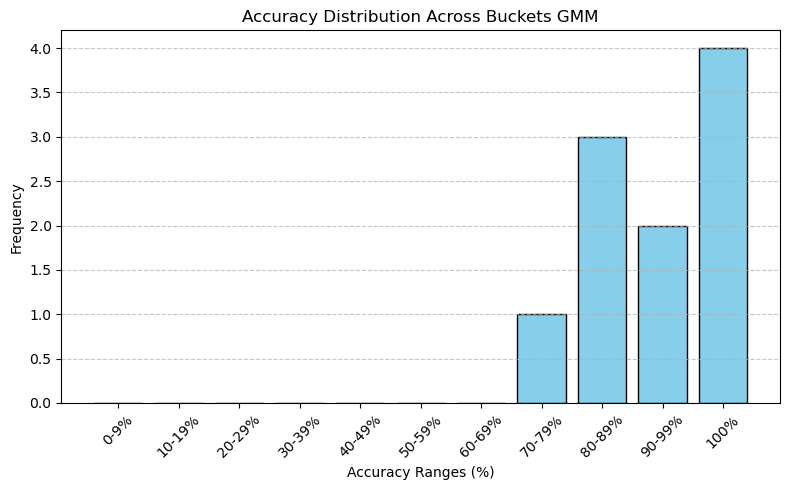

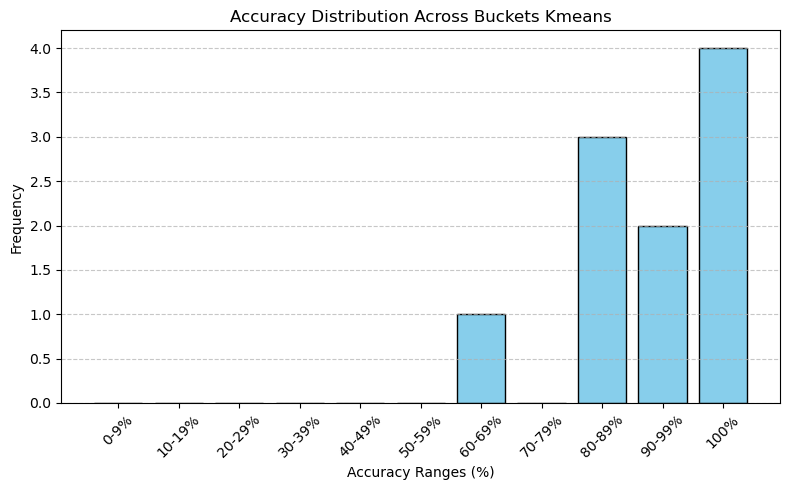

In [12]:
utils.plot_accuracy_metric(accuracy_buckets_pfn, 'pfn')
utils.plot_accuracy_metric(accuracy_buckets_gmm, 'GMM')
utils.plot_accuracy_metric(accuracy_buckets_kmeans, 'Kmeans')